In [3]:
from core.NeuralNet.MLP import MLP
from core.experiments.utils import (save_experiment_results_to_file, evaluate_model)
from core.experiments.ContextClasses import (DataContext, TrainingContext)
from core.experiments.binary_classification.binary_classification_experiment import (
    BinaryClassificationExperiment,
)
from config.config import (
    TRIPLES_PATH,
    ENTITIES_LABELS_PATH,
    PROPERTIES_LABELS_PATH,
    GRAPH_EMBEDDINGS_PATH,
    EXPERIMENT_RESULTS_PATH
)
from core.NeuralNet.GNN import GCN
from loguru import logger
import sys
import torch
# For Multi class type classification
from core.ToTorch.DataBuilder import NodeTypeDataBuilder
from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.nn import GCNConv,MessagePassing

import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', 0)
import matplotlib.pyplot as plt
import os

import datetime

In [2]:
base_path= "./data/question_embeddings"
os.path.join(base_path, "entities.csv")

'./data/question_embeddings\\entities.csv'

In [13]:
base_path= "./data/question_embeddings"
filename = "entities.csv"
fp = os.path.join("./data/question_embeddings", "entities.csv")
print(fp)
os.path.join("./data/question_embeddings", "entities.csv")

./data/question_embeddings\entities.csv


'./data/question_embeddings\\entities.csv'

In [5]:
dic = {'a':1,'b':2}

for key in dic:
    print('key ',key,':',' Value ',dic[key])
key, val = enumerate(dic)
print(key,val)


key  a :  Value  1
key  b :  Value  2
(0, 'a') (1, 'b')


## Multi class classification

In [14]:
#databuilder
data_builder = NodeTypeDataBuilder(
    triples_path=TRIPLES_PATH,
    entities_labels_path=ENTITIES_LABELS_PATH,
    properties_labels_path=PROPERTIES_LABELS_PATH,
    embeddings_path=GRAPH_EMBEDDINGS_PATH,
    labeler=None,
)
data_builder

In [15]:
x = data_builder.get_x()
edge_index = data_builder.get_edge_index()
y = data_builder.get_y()
train_mask, val_mask, test_mask = data_builder.get_entities_masks()

data = Data(
    x=x,
    edge_index=edge_index,
    y=y,
    train_mask=train_mask,
    val_mask=val_mask,
    test_mask=test_mask,
)


In [16]:
data

Data(x=[57047, 768], edge_index=[2, 545165], y=[57047], train_mask=[57047], val_mask=[57047], test_mask=[57047])

In [23]:
print('Total Classes: ',len(set(data.y.tolist())))

Total Classes:  105


In [17]:
class GCN_test(torch.nn.Module):
    def __init__(self, num_node_features, dim_hidden_layer,num_layers, num_classes):
        super().__init__()
        #self.conv1 = GCNConv(num_node_features, dim_hidden_layer)
        #self.conv2 = GCNConv(dim_hidden_layer, num_classes)
        layers = []
        input_dim, output_dim = num_node_features, dim_hidden_layer

        for _ in range(num_layers-1):
            layers = layers+[GCNConv(in_channels=input_dim,out_channels=output_dim),torch.nn.ReLU(),torch.nn.Dropout(p=0.2)]
            
            input_dim = dim_hidden_layer
        layers = layers+[GCNConv(in_channels=input_dim,out_channels=num_classes)]
        self.layers = torch.nn.ModuleList(layers)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        embeddings = []
        for layer in self.layers:
            if isinstance(layer,MessagePassing):
                x = layer(x,edge_index)
                embeddings.append(x.clone())
            else:
                x=layer(x)
            
        return F.log_softmax(x, dim=1), embeddings

In [18]:
NUM_EPOCHS = 10

In [20]:
# TRAIN MLP
logger.info("Training MLP")
mlp_model = MLP(
    num_node_features=data.num_node_features, dim_hidden_layer=16, num_classes=len(set(data.y.tolist()))
)
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=0.01, weight_decay=5e-4)
mlp_model.train()

for epoch in range(NUM_EPOCHS):
    optimizer.zero_grad()
    out = mlp_model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    if epoch%1==0:
        logger.debug(f"Epoch: {epoch:03d}, Loss: {loss:.4f}")

2023-08-10 10:56:53.173 | INFO     | __main__:<module>:2 - Training MLP
2023-08-10 10:56:53.323 | DEBUG    | __main__:<module>:16 - Epoch: 000, Loss: 4.7041
2023-08-10 10:56:53.465 | DEBUG    | __main__:<module>:16 - Epoch: 001, Loss: 4.6738
2023-08-10 10:56:53.593 | DEBUG    | __main__:<module>:16 - Epoch: 002, Loss: 4.6445
2023-08-10 10:56:53.731 | DEBUG    | __main__:<module>:16 - Epoch: 003, Loss: 4.6098
2023-08-10 10:56:53.865 | DEBUG    | __main__:<module>:16 - Epoch: 004, Loss: 4.5687
2023-08-10 10:56:54.006 | DEBUG    | __main__:<module>:16 - Epoch: 005, Loss: 4.5210
2023-08-10 10:56:54.142 | DEBUG    | __main__:<module>:16 - Epoch: 006, Loss: 4.4670
2023-08-10 10:56:54.285 | DEBUG    | __main__:<module>:16 - Epoch: 007, Loss: 4.4039
2023-08-10 10:56:54.420 | DEBUG    | __main__:<module>:16 - Epoch: 008, Loss: 4.3362
2023-08-10 10:56:54.560 | DEBUG    | __main__:<module>:16 - Epoch: 009, Loss: 4.2598


In [21]:
mlp_model.eval()
pred = mlp_model(data).argmax(dim=1)
correct_predictions_mask = pred[data.test_mask] == data.y[data.test_mask]
incorrect_predictions_mask = pred[data.test_mask] != data.y[data.test_mask]
accuracy = sum(correct_predictions_mask)/len(correct_predictions_mask)
print("MLP accuracy",'{:.2%}'.format(accuracy.item()))

MLP accuracy 22.36%


In [24]:
# TRAIN GNN
logger.info("Training GNN")
model = GCN_test(
    num_node_features=data.num_node_features, dim_hidden_layer=256,num_layers=3, num_classes=len(set(data.y.tolist()))
)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
model.train()

for epoch in range(NUM_EPOCHS):
    optimizer.zero_grad()
    out,embedding = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    if epoch%1==0:
        logger.debug(f"Epoch: {epoch:03d}, Loss: {loss:.4f}")

2023-08-10 10:58:21.594 | INFO     | __main__:<module>:2 - Training GNN
2023-08-10 10:58:25.648 | DEBUG    | __main__:<module>:16 - Epoch: 000, Loss: 4.6702
2023-08-10 10:58:30.789 | DEBUG    | __main__:<module>:16 - Epoch: 001, Loss: 4.0498
2023-08-10 10:58:34.704 | DEBUG    | __main__:<module>:16 - Epoch: 002, Loss: 3.6241
2023-08-10 10:58:38.551 | DEBUG    | __main__:<module>:16 - Epoch: 003, Loss: 3.4093
2023-08-10 10:58:42.359 | DEBUG    | __main__:<module>:16 - Epoch: 004, Loss: 3.1806
2023-08-10 10:58:45.586 | DEBUG    | __main__:<module>:16 - Epoch: 005, Loss: 3.3679
2023-08-10 10:58:48.840 | DEBUG    | __main__:<module>:16 - Epoch: 006, Loss: 3.0339
2023-08-10 10:58:51.971 | DEBUG    | __main__:<module>:16 - Epoch: 007, Loss: 3.0493
2023-08-10 10:58:55.171 | DEBUG    | __main__:<module>:16 - Epoch: 008, Loss: 3.0731
2023-08-10 10:58:58.430 | DEBUG    | __main__:<module>:16 - Epoch: 009, Loss: 3.0684


In [25]:
model.eval()
pred_,_ = model(data)
pred = pred_.argmax(dim=1)
correct_predictions_mask = pred[data.test_mask] == data.y[data.test_mask]
incorrect_predictions_mask = pred[data.test_mask] != data.y[data.test_mask]
accuracy = sum(correct_predictions_mask)/len(correct_predictions_mask)
print("GCN testing accuracy",'{:.2%}'.format(accuracy.item()))

GCN testing accuracy 16.90%


In [26]:
model.eval()
pred_,_ = model(data)
pred = pred_.argmax(dim=1)
correct_predictions_mask = pred[data.val_mask] == data.y[data.val_mask]
incorrect_predictions_mask = pred[data.val_mask] != data.y[data.val_mask]
accuracy = sum(correct_predictions_mask)/len(correct_predictions_mask)
print("GCN Validation accuracy",'{:.2%}'.format(accuracy.item()))

GCN Validation accuracy 17.05%


In [27]:
model.eval()
pred_,_ = model(data)
pred = pred_.argmax(dim=1)
correct_predictions_mask = pred[data.train_mask] == data.y[data.train_mask]
incorrect_predictions_mask = pred[data.train_mask] != data.y[data.train_mask]
accuracy = sum(correct_predictions_mask)/len(correct_predictions_mask)
print("GCN Training accuracy",'{:.2%}'.format(accuracy.item()))

GCN Training accuracy 16.05%


Text(0.5, 1.0, 'Class distribution (Testing)')

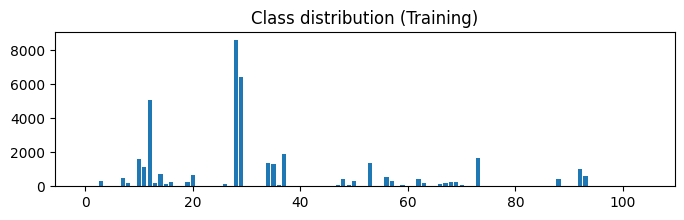

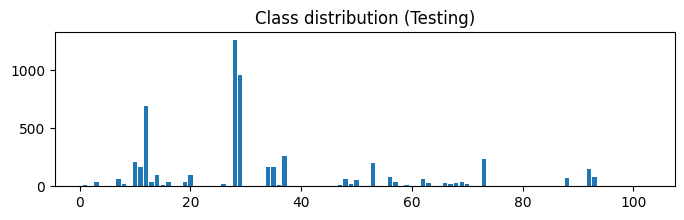

In [28]:
classes, value_counts = np.unique(data.y[data.train_mask].numpy(), return_counts=True)
fig, ax = plt.subplots(figsize=(8, 2))
ax.bar(classes,value_counts)
ax.set_title('Class distribution (Training)')
classes, value_counts = np.unique(data.y[data.test_mask].numpy(), return_counts=True)
fig, ax = plt.subplots(figsize=(8, 2))
ax.bar(classes,value_counts)
ax.set_title('Class distribution (Testing)')

In [6]:
# Read experiments file
exp_res = pd.read_csv(os.path.join(EXPERIMENT_RESULTS_PATH["eval_results"],"experiments.csv"))
exp_res

,time_stamp,info,Epochs,Learning Rate,hidden_layer_dimension,Model,accuracy,precision,recall,F1,model_directory,triples_path,entities_labels_path,properties_labels_path,graph_embeddings_path
0,2023:08:09 12:55:30,Task: multiclass node type prediction,10,0.01,16,"GCN(\r\n (conv1): GCNConv(768, 16)\r\n (conv2): GCNConv(16, 99)\r\n)",21.08%,NaN,NaN,NaN,./core/experiments/multi_class_classification/results\20230809125527,./data/source_data/VAD_triples.csv,./data/source_data/VAD_entities_labels.csv,./data/source_data/VAD_properties_labels.csv,./data/graph_embeddings
1,2023:08:09 16:08:58,Task: multiclass node type prediction,10,0.01,256,"GCN(\r\n (layers): ModuleList(\r\n (0): GCNConv(768, 256)\r\n (1): ReLU()\r\n (2): Dropout(p=0.2, inplace=False)\r\n (3): GCNConv(256, 256)\r\n (4): ReLU()\r\n (5): Dropout(p=0.2, inplace=False)\r\n (6): GCNConv(256, 99)\r\n )\r\n)",18.81%,NaN,NaN,NaN,./core/experiments/multi_class_classification/results\20230809160845,./data/source_data/VAD_triples.csv,./data/source_data/VAD_entities_labels.csv,./data/source_data/VAD_properties_labels.csv,./data/graph_embeddings
2,2023:08:09 16:33:34,Task: multiclass node type prediction,1000,0.01,256,"GCN(\r\n (layers): ModuleList(\r\n (0): GCNConv(768, 256)\r\n (1): ReLU()\r\n (2): Dropout(p=0.2, inplace=False)\r\n (3): GCNConv(256, 256)\r\n (4): ReLU()\r\n (5): Dropout(p=0.2, inplace=False)\r\n (6): GCNConv(256, 99)\r\n )\r\n)",88.37%,NaN,NaN,NaN,./core/experiments/multi_class_classification/results\20230809161415,./data/source_data/VAD_triples.csv,./data/source_data/VAD_entities_labels.csv,./data/source_data/VAD_properties_labels.csv,./data/graph_embeddings


In [13]:
exp_res.columns

Index(['time_stamp', 'info', 'Epochs', 'Learning Rate',
       'hidden_layer_dimension', 'Model', 'accuracy', 'precision', 'recall',
       'F1', 'model_directory', 'triples_path', 'entities_labels_path',
       'properties_labels_path', 'graph_embeddings_path'],
      dtype='object')

In [55]:
entities = pd.read_csv('data/source_data/VAD_entities.csv')
entities_list = entities['uri'].tolist()
embed_path = 'core/experiments/multi_class_classification/results/20230810110230/embeddings.pt'
embed_data = torch.load(embed_path)
embed_list  = embed_data[1].numpy()
len(embed_data)

3

In [57]:
result_dict = {}
for entity, embedding in zip(entities_list,embed_list):
    result_dict[entity]=embedding

In [58]:
entity_encodings_path = os.path.join('C:/Users/I583773/Documents/Thesis', "VAD_embeddings")
np.savez(entity_encodings_path, **result_dict)

In [52]:
loaded_data = np.load('C:/Users/I583773/Documents/Thesis/VAD_embeddings.npz', allow_pickle=True)

In [53]:
loaded_data

NpzFile 'C:/Users/I583773/Documents/Thesis/trained_embeddings.npz' with keys: http://www.signavio.com/opal/, http://www.signavio.com/opal/APQC/PPM/PF/0%20Root%20-%20Cross%20Industry, http://www.signavio.com/opal/APQC/PPM/PF/1.0%20Develop%20Vision%20and%20Strategy%20-%20Cross%20Industry, http://www.signavio.com/opal/APQC/PPM/PF/1.1%20Define%20the%20business%20concept%20and%20long-term%20vision%20-%20Cross%20Industry, http://www.signavio.com/opal/APQC/PPM/PF/1.1.1%20Assess%20the%20external%20environment%20-%20Cross%20Industry...